<a href="https://colab.research.google.com/github/moonryul/course-v3/blob/master/Copy_of_lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *


-----------------------------------------
Comment by Moon R. Jung: Getting the data: You're supposed to get the data from the following Kaggle site:
https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview

But The data seems missing from the above  Kaggle site. If you encounter problems with using fastai, it is often useful to consult forum.fast.ai:
In this case, the site https://forums.fast.ai/t/lesson-3-cant-download-planet-data-images-tar-archive/60309/38 talks about the data missing issue. 

(1) Fortunately some person uploaded the data into another kaggle.com folder: 

https://www.kaggle.com/nikitarom/planets-dataset

(2) So, follow the original notebook by using the different site. 
(3) I modified the original notebook accordingly. 
(4) In summary: use
! kaggle datasets download nikitarom/planets-dataset -p "{path}"
! unzip -q -n '{path}'/planets-dataset.zip -d '{path}' 


path.ls()


(5) Use file train_class.csv and train-jpg folder downloaded into  "content" folder of your Colab remote machine. 
******************************

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
! {sys.executable} -m pip install kaggle --upgrade
# The above command installs "kaggle" command into your Colab remote machine. 
# You will this "kaggle" later in this notebook. 

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.8)


Important: Login to kaggle [you need to sign in to Kaggle site first] and click on your profile picture on the top right corner and you will the rundown menu; click  'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'. You will find this file in Download folder of your local PC.

Upload this file to "content" folder of your Colab remote machine: Click "content" folder and click "..." icon on the right of this folder. You will see  "Upload" on the rundown menu. Uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [ ]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
#!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [4]:
base_dir = '/content/'
path = Path(base_dir)
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content')

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
#! unzip -q -n "{path}/train_v2.csv.zip" -d "{path}

In [5]:
! kaggle datasets download nikitarom/planets-dataset -p '{path}'
! unzip -q -n '{path}'/planets-dataset.zip -d '{path}'
path.ls()

 98% 1.47G/1.50G [00:15<00:00, 135MB/s]
100% 1.50G/1.50G [00:15<00:00, 101MB/s]


[PosixPath('/content/.config'),
 PosixPath('/content/Miniconda3-4.5.4-Linux-x86_64.sh'),
 PosixPath('/content/PlanetFolderStructure.png'),
 PosixPath('/content/planets-dataset.zip'),
 PosixPath('/content/planet'),
 PosixPath('/content/kaggle.json'),
 PosixPath('/content/data'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/test-jpg-additional'),
 PosixPath('/content/sample_data')]

After you downloaded the kaggle dataset, the folder structure of youre colab remote machine will look like: [The file strucrure of "content" folder](//drive.google.com/uc?id=1254t86lPvSsB5OJ7De2W3VyjQ1UUDmf6)

In [ ]:
# The above statement uses "conda" command which is supposed to installed in your colab
# remote machine. It is not so by default. Confer to https://stackoverflow.com/questions/59330876/install-conda-package-to-google-colab
# on how to install conda. Do the following:

# !wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
# !chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
# !bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
# # update 1
# !conda install -q -y --prefix /usr/local python=3.6 ujson
# # update 2
# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages')
# # test it
# import ujson
# print(ujson.dumps({1:2}))

In [ ]:
#! conda install --yes  --prefix {sys.prefix} -c haasad eidl7zip


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [6]:
df = pd.read_csv(path/'planet'/'planet'/'train_classes.csv')
df.head()
path

PosixPath('/content')

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [9]:
np.random.seed(42)
src = (ImageList.from_csv(path/'planet'/'planet', 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [10]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

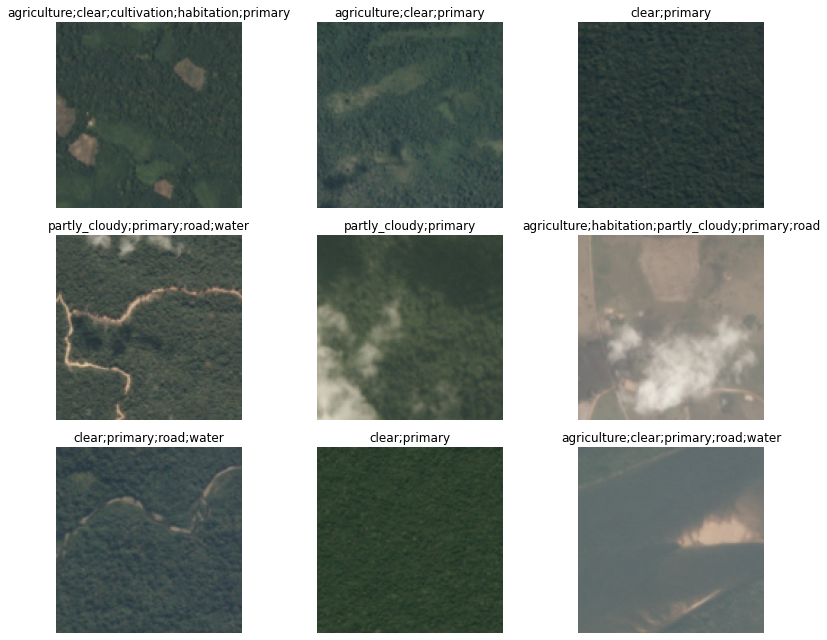

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


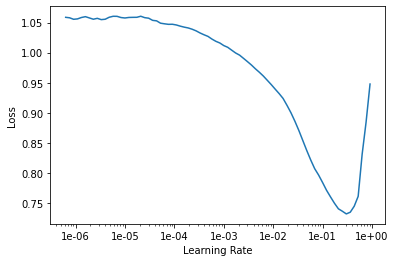

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))
#https://forums.fast.ai/t/what-does-the-slice-lr-mean-in-fit-one-cycle/60896/4

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135085,0.116071,0.946067,0.898326,02:42
1,0.114228,0.101160,0.950936,0.911155,02:34
2,0.103125,0.092988,0.950086,0.917575,02:32
3,0.094089,0.088909,0.956052,0.923841,02:30
4,0.093587,0.087278,0.956313,0.924826,02:31


In [ ]:
slice(lr)

slice(None, 0.01, None)

In [ ]:
learn.fit_one_cycle??


In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)